In [1]:
import ujson as json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import requests


api_url = 'http://localhost:7070/api/ptt/query'

headers = {
    'Content-Type': 'application/json'
}
def create_query_template(field):
    return {
        "operations": {
            "feature": {"type": "RETRIEVER", "field": field, "input": "text"},
            "relations": {"type": "TRANSFORMER", "transformerName": "RelationExpander", "input": "feature"},
            "lookup": {"type": "TRANSFORMER", "transformerName": "FieldLookup", "input": "relations"},
            "aggregator": {"type": "TRANSFORMER", "transformerName": "ScoreAggregator", "input": "lookup"},
            "filelookup": {"type": "TRANSFORMER", "transformerName": "FieldLookup", "input": "aggregator"}
        },
        "context": {
            "global": {"limit": "1000"},
            "local": {
                "lookup": {"field": "time", "keys": "start, end"},
                "relations": {"outgoing": "partOf"},
                "filelookup": {"field": "file", "keys": "path"}
            }
        },
        "output": "filelookup"
    }

query_mix = {
        "operations": {
            "feature1" : {"type": "RETRIEVER", "field": "clip", "input": "input"},
            "feature2" : {"type": "RETRIEVER", "field": "ocr_sparse", "input": "input"},
            "feature3" : {"type": "RETRIEVER", "field": "asr_sparse", "input": "input"},
            "feature4" : {"type": "RETRIEVER", "field": "caption_sparse", "input": "input"},
            "feature5" : {"type": "RETRIEVER", "field": "ocr_dense", "input": "input"},
            "feature6" : {"type": "RETRIEVER", "field": "asr_dense", "input": "input"},
            "feature7" : {"type": "RETRIEVER", "field": "caption_dense", "input": "input"},
            "feature1_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature1"},
            "feature2_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature2"},
            "feature3_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature3"},
            "feature4_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature4"},
            "feature5_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature2"},
            "feature6_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature3"},
            "feature7_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature4"},
            "score" : {"type": "AGGREGATOR", "aggregatorName": "WeightedScoreFusion", "inputs": ["feature1_exaggerated", "feature2_exaggerated", "feature3_exaggerated", "feature4_exaggerated", "feature5_exaggerated", "feature6_exaggerated", "feature7_exaggerated"]},
            "relations" : {"type": "TRANSFORMER", "transformerName": "RelationExpander", "input": "score"},
            "lookup" : {"type": "TRANSFORMER", "transformerName": "FieldLookup", "input": "relations"},
            "aggregator" : {"type": "TRANSFORMER", "transformerName": "ScoreAggregator",  "input": "lookup"},
            "filelookup" : {"type": "TRANSFORMER", "transformerName": "FieldLookup", "input": "aggregator"}
        },
        "context": {
            "global": {
                "limit": "1000"
            },
            "local" : {
                "feature1_exaggerated": {"factor": "1.0"},
                "feature2_exaggerated": {"factor": "1.0"},
                "feature3_exaggerated": {"factor": "1.0"},
                "feature4_exaggerated": {"factor": "1.0"},
                "feature5_exaggerated": {"factor": "1.0"},
                "feature6_exaggerated": {"factor": "1.0"},
                "feature7_exaggerated": {"factor": "1.0"},
                "lookup": {"field": "time", "keys": "start, end"},
                "relations" : {"outgoing": "partOf"},				
                "filelookup": {"field": "file", "keys": "path"},
				"score": {"weights": "0.5,0.2,0.2,0.1"}
            }
        },
        "output": "filelookup"
}

In [314]:
iou_results = []
mrr_results = []



In [315]:
def query_ve(query, query_template):
    response = requests.post(api_url, json=query_template, headers=headers)

    if response.status_code == 200:
        response_data = response.json()
        return {
            "query": query,
            "response": response_data
        }
    
    else:
        print(f"Request failed with status code {response.status_code}")
        print(f"Query text: {query['query']}")
        print("Response content:", response.content)

def combined_query_ve(query, query_template, weights, p, exag_factor, normalize):
    query_template["inputs"] = {
                "input": {"type": "TEXT", "data": query["query"]}
        }
    query_template["context"]["local"]["score"]["weights"] = weights
    query_template["context"]["local"]["feature1_exaggerated"]["factor"] = str(exag_factor[0])
    query_template["context"]["local"]["feature2_exaggerated"]["factor"] = str(exag_factor[1])
    query_template["context"]["local"]["feature3_exaggerated"]["factor"] = str(exag_factor[2])
    query_template["context"]["local"]["feature4_exaggerated"]["factor"] = str(exag_factor[3])
    query_template["context"]["local"]["score"]["p"] = str(p)
    query_template["context"]["local"]["score"]["normalize"] = str(normalize)
    print(json.dumps(query_template))
    return query_ve(query, query_template)

def single_query_ve(query, query_template):
    query_template["inputs"] = {"text": {"type": "TEXT", "data": query["query"]}}
    return query_ve(query, query_template)

In [375]:
benchmark_queries = 've-benchmarking/benchmark_queries.json'
results_path = 've-benchmarking/query_results/'

with open(benchmark_queries, 'r') as file:
    queries = json.load(file)

# weight_clip = 1
# weight_ocr = 0.0000001
# weight_asr = 0.0000001
# weight_caption = 0.001
# weights = f"{weight_clip},{weight_ocr},{weight_asr},{weight_caption}"
# exag_factor = [1, 1, 1, 1]
# p = 1

weight_clip = 1
weight_ocr = 1
weight_asr = 1
weight_caption = 1
weights = f"{weight_clip},{weight_ocr},{weight_asr},{weight_caption}"
exag_factor = [1, 0.01, 0.4, 0.3]
p = 999
normalize=True

label = f"clip {weight_clip:.2f} ocr {weight_ocr:.2f} asr {weight_asr:.2f} caption {weight_caption:.2f} exag{exag_factor}_p_{p}"

if not normalize:
    label += " no_norm"


results_mix = []
for query in queries:
    results_mix.append(combined_query_ve(query, query_mix, weights, p, exag_factor=exag_factor, normalize=normalize))







{"operations":{"feature1":{"type":"RETRIEVER","field":"clip","input":"clip"},"feature2":{"type":"RETRIEVER","field":"ocr_sparse","input":"ocr"},"feature3":{"type":"RETRIEVER","field":"asr_sparse","input":"asr"},"feature4":{"type":"RETRIEVER","field":"caption_sparse","input":"caption"},"feature1_exaggerated":{"type":"TRANSFORMER","transformerName":"ScoreExaggerator","input":"feature1"},"feature2_exaggerated":{"type":"TRANSFORMER","transformerName":"ScoreExaggerator","input":"feature2"},"feature3_exaggerated":{"type":"TRANSFORMER","transformerName":"ScoreExaggerator","input":"feature3"},"feature4_exaggerated":{"type":"TRANSFORMER","transformerName":"ScoreExaggerator","input":"feature4"},"score":{"type":"AGGREGATOR","aggregatorName":"WeightedScoreFusion","inputs":["feature1_exaggerated","feature2_exaggerated","feature3_exaggerated","feature4_exaggerated"]},"relations":{"type":"TRANSFORMER","transformerName":"RelationExpander","input":"score"},"lookup":{"type":"TRANSFORMER","transformerNam

In [376]:
def iou(query, candidate):
    # convert nanoseconds to seconds
    candidate_start = int(candidate["properties"]["start"]) / 1000000000.0
    candidate_end = int(candidate["properties"]["end"]) / 1000000000.0
    truth_start = query["segments"][0][0]
    truth_end = query["segments"][0][1]

    intersection = min(truth_end,candidate_end)-max(truth_start,candidate_start)
    if intersection < 0:
        # negative intersection = no overlap = IOU 0
        return 0.0
    
    union = (candidate_end-candidate_start) + (truth_end-truth_start) - intersection
    return intersection/union

In [377]:
def format_iou(query, method, rank):
    # considers only first result
    if "segments" in query["query"] and len(query["response"]["retrievables"])>0 and "start" in query["response"]["retrievables"][rank]["properties"]: 
        iou_score = iou(query["query"],query["response"]["retrievables"][rank])
        return {
            "iou": iou_score,
            "method": method,
            "class": query["query"]["tag"][0]
        }


In [378]:
def rank(query, candidates):
    truth = query["files"]
    rank = float("inf")
    for i in range(len(candidates)):
        cand_file = os.path.basename(candidates[i]["properties"]["path"])
        if cand_file in truth:
            rank = i+1
            break

    return rank

In [379]:
def format_mrr(query, method):
    if len(query["response"]["retrievables"]) > 0:
        res_rank = rank(query["query"], query["response"]["retrievables"])
        if res_rank == float("inf"):
            score = None
        else:
            score = query["response"]["retrievables"][res_rank-1]["score"]
        return {
            "rank": res_rank,
            "mrr": 1.0/res_rank,
            "method": method,
            "class": query["query"]["tag"][0],
            "score": score,
            "top_score": query["response"]["retrievables"][0]["score"]
        }

## Intersection-over-union for video retrievables, MRR for image retrievables

In [380]:

for result in results_mix:
    iou_results.append(format_iou(result, label, 0))
    mrr_results.append(format_mrr(result, label))

In [381]:
mrr_df = pd.DataFrame([r for r in mrr_results if r is not None])
iou_df = pd.DataFrame([r for r in iou_results if r is not None])

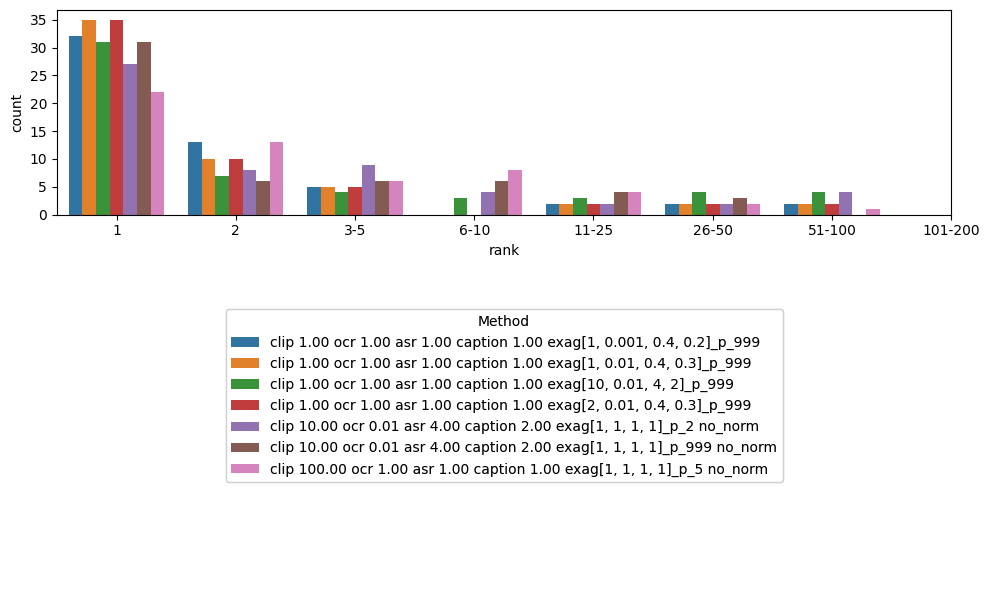

In [382]:

cutoffs = [1,2,5,10,25,50,100,200]
# Create a DataFrame with bins and counts for each method
hist_data = []
for method_group in mrr_df.groupby("method"):
    method_name, method_group = method_group
    counts, _ = np.histogram(method_group["rank"], bins=cutoffs)
    hist_data.extend({"method": method_name, "rank": bin, "count": count} for bin, count in zip(cutoffs, counts))

hist_df = pd.DataFrame(hist_data)

import matplotlib.gridspec as gridspec
# Create the figure and gridspec
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5])

# Upper plot
ax0 = plt.subplot(gs[0])
sns.barplot(data=hist_df, x="rank", y="count", hue="method", dodge=True, ax=ax0)

xticklabels = ["1", "2", "3-5", "6-10", "11-25", "26-50", "51-100", "101-200"]
ax0.set_xticks(range(len(xticklabels)))
ax0.set_xticklabels(xticklabels)
ax0.set_yticks(range(0, max(hist_df["count"]) + 1, 5))

# Remove the legend from the upper plot
ax0.legend_.remove()

# Lower plot for legend
ax1 = plt.subplot(gs[1])
ax1.axis('off')  # Turn off the axis
legend = ax1.legend(*ax0.get_legend_handles_labels(), loc='center', title="Method", bbox_to_anchor=(0.5, 0.6))
ax1.add_artist(legend)

# Show the plot
plt.tight_layout()
plt.show()

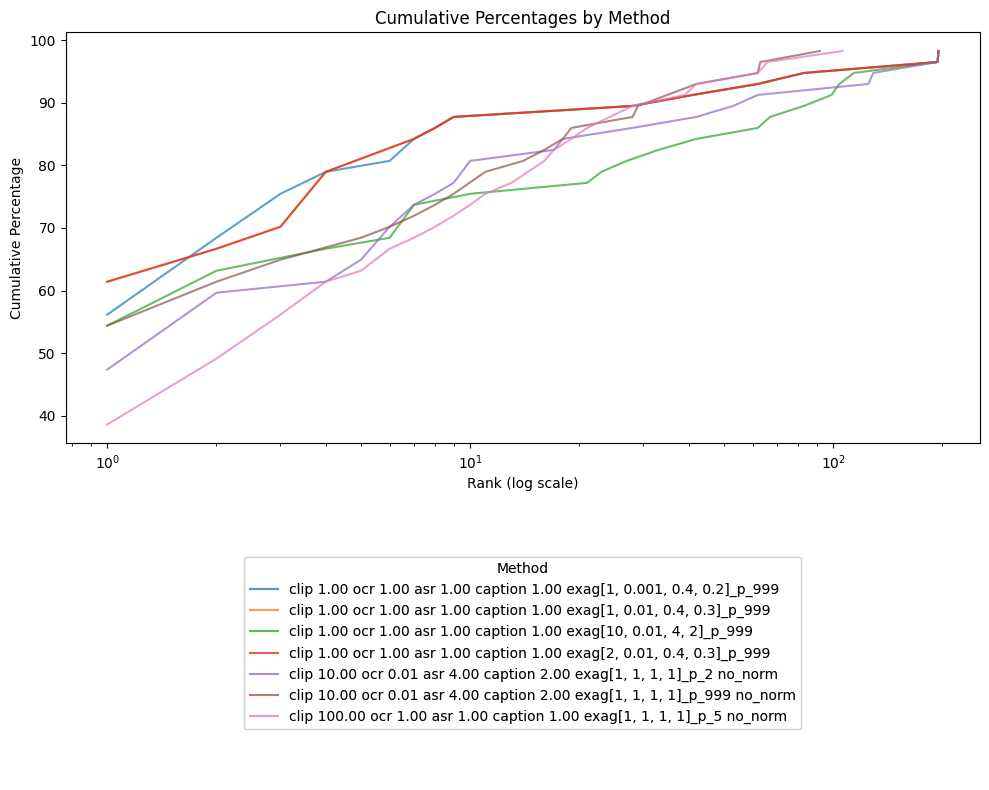

In [383]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming mrr_df is already defined and contains the data
# Example mrr_df:
# mrr_df = pd.DataFrame({
#     "method": np.random.choice(["method1", "method2", "method3"], size=100),
#     "rank": np.random.randint(1, 200, size=100)
# })

# Create a DataFrame with cumulative counts for each method without bins
# Calculate cumulative data
cumulative_data = []
for method_name, method_group in mrr_df.groupby("method"):
    # Sort the ranks
    sorted_ranks = np.sort(method_group["rank"])
    cumulative_counts = np.arange(1, len(sorted_ranks) + 1)
    cumulative_data.extend({"method": method_name, "rank": rank, "cumulative_count": cum_count} 
                           for rank, cum_count in zip(sorted_ranks, cumulative_counts))

cumulative_df = pd.DataFrame(cumulative_data)

# Group by method and rank to sum cumulative counts
cumulative_df = cumulative_df.groupby(['method', 'rank']).size().groupby(level=0).cumsum().reset_index(name='cumulative_count')

# Normalize cumulative counts to percentages
total_counts = cumulative_df.groupby('method')['cumulative_count'].transform('max')
cumulative_df['cumulative_percent'] = (cumulative_df['cumulative_count'] / total_counts) * 100

# Create the figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])

# Upper plot for the cumulative percentage plot
ax0 = plt.subplot(gs[0])
sns.lineplot(data=cumulative_df, x="rank", y="cumulative_percent", hue="method", ax=ax0, alpha=0.7, markers=True)

ax0.set_xscale("log")
ax0.set_xlabel("Rank (log scale)")
ax0.set_ylabel("Cumulative Percentage")
ax0.set_title("Cumulative Percentages by Method")

# Remove the legend from the upper plot
ax0.legend_.remove()

# Lower plot for legend
ax1 = plt.subplot(gs[1])
ax1.axis('off')  # Turn off the axis
legend = ax1.legend(*ax0.get_legend_handles_labels(), loc='center', title="Method", bbox_to_anchor=(0.5, 0.5))
ax1.add_artist(legend)

# Adjust layout to make space for the legend
plt.tight_layout()
plt.show()

